<a href="https://colab.research.google.com/github/sarthakbiswas97/design-llm-apps-exercises/blob/main/Decoding_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# generate the next five tokens (words or subwords).
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)

model.eval()

text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)
print(f"Input Ids: {input_ids}")

print(f"without squeezing: {model.generate(input_ids)}")

outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5)
print(f"Outputs: {outputs}")
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated text: {generated_text}")

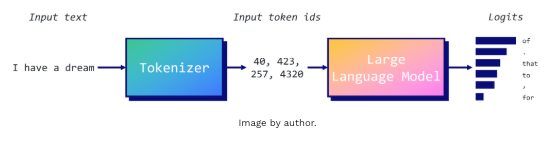

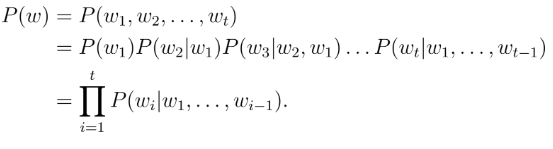

# Greedy search implementation
using graphviz and networkx. We select the ID with the highest score, compute its log probability (we take the log to simplify calculations), and add it to the tree. We’ll repeat this process for five tokens.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

def get_log_prob(logits, token_id):
    # Compute the softmax of the logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)

    # Get the log probability of the token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)

    # Compute the score of the predicted token
    token_score = get_log_prob(logits, token_id)

    # Add the predicted token to the list of input ids
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    # Add node and edge to graph
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length-1)

    return input_ids

# Parameters
length = 5
beams = 1

# Create a balanced tree with height 'length'
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

# Start generating text
output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

In [ ]:
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalize the colors along the range of token scores
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)

    # Draw the nodes
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4,
                          node_color=scores, cmap=cmap)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

# Plot graph
plot_graph(graph, length, 1.5, 'token')

In [ ]:
from tqdm.notebook import tqdm

def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices

def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]

    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        # Compute the score of the predicted token
        token_score = get_log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # Add the predicted token to the list of input ids
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Add node and edge to graph
        token = tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

        # Recursive call
        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, 1)

# Parameters
length = 5
beams = 2

# Create a balanced tree with height 'length' and branching factor 'k'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = text

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)

def get_best_sequence(G):
    # Create a list of leaf nodes
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]

    # Get the leaf node with the highest cumscore
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

    # Retrieve the sequence of nodes from this leaf node to the root node in a list
    path = nx.shortest_path(G, source=0, target=max_score_node)

    # Return the string of token attributes of this sequence
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])

    return sequence, max_score

sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

In [ ]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')